In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
from network.examples import community, virus
from network.simulation import rv, test
from network.randoms import fix_random
from network.graph import Graph

import random

import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
n_communities = 1000
community_size = 3
orphans = 1000
total_ppl = n_communities * community_size + orphans

# assume 3 strong connections per person
n_strong_conns = total_ppl * 3
# assume 6 weak connections per person
n_weak_conns = total_ppl * 6

core_kw = dict(strength=0.8)

def strong_kw_func(strength):
    def func():
        days_together = random.randint(1, 5)
        p_together = days_together / 7
        return dict(strength=p_together * strength)

    return func

strong_kw = strong_kw_func(strength=0.8)
weak_kw = dict(strength=0.1)

def generate_graph():
    graph, node_community_map = community.community_graph(
        n_communities, community_size, orphans,
        n_strong_conns, n_weak_conns,
        core_kw=core_kw, strong_kw=strong_kw, weak_kw=weak_kw
    )
    return graph

In [85]:
def reset_weak_edges(graph, strength):
    edges_to_remove = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'weak']
    for prev_weak_edge in edges_to_remove:
        graph.remove_edge(prev_weak_edge.nodes)

    # generate edges will generate both outbound and inbound edges so we only need to /2
    n_new_weak_edges = int(len(edges_to_remove) / 2)
    for new_weak_edge in community.generate_edges(graph, n_new_weak_edges):
        graph.add_edge(new_weak_edge, kind='weak', strength=strength)
        
def no_mitigation(transmission):
    for step in transmission:
        yield step
        reset_weak_edges(transmission.graph, weak_kw['strength'])

In [105]:
def enact_quarantine(graph):
    def should_remove_edge(edge):
        if edge.attr('kind') == 'strong':
            return True
        if edge.attr('kind') == 'weak' and test(0.75):
            return True
        return False
    
    edges_to_remove = [e for e in graph.iter_edges() if should_remove_edge(e)]
    for edge in edges_to_remove:
        graph.remove_edge(edge.nodes)

def quarantine(quarantine_limit):
    def runner(transmission):
        broadcasts = 0
        in_quarantine = False
        for step in transmission:
            yield step
            dbroadcast = transmission.broadcasts - broadcasts
            if dbroadcast > quarantine_limit and not in_quarantine:
                print(f'Quarantine enacted at step: {transmission.steps}')
                enact_quarantine(transmission.graph)
                in_quarantine = True
            else:
                reset_weak_edges(transmission.graph, weak_kw['strength'])
            broadcasts = transmission.broadcasts
            
    return runner

In [118]:
def put_on_masks(graph, mask_factor=0.2, mask_factor_core=0.85, perc_masks=1.0):
    for edge in graph.iter_edges():
        if edge.attr('kind') == 'core':
            graph.update_edge(edge.nodes, strength=mask_factor_core * edge.attr('strength'))  
        elif test(perc_masks):
            graph.update_edge(edge.nodes, strength=mask_factor * edge.attr('strength'))

def masked_runner(mask_day, perc_masks):
    def runner(transmission):
        for step in transmission:
            yield step
            reset_weak_edges(transmission.graph, weak_kw['strength'])
            if transmission.steps >= mask_day:
                put_on_masks(transmission.graph, perc_masks=perc_masks)
            
    return runner

In [87]:
def generate_sim(graph, runner):
    return virus.virus_simulation(
        graph=graph,
        patient0=1,
        incubation_period=rv.randint(2, 14),
        contagious_for=rv.choice(0, 1, 7),
        runner=runner
    )

In [89]:
graph0 = generate_graph()

In [119]:
graph_quarantine40 = Graph.duplicate(graph0)
quarantine_40 = generate_sim(graph_quarantine40, quarantine(40))

with fix_random():
    quarantine_40.path(70)

Quarantine enacted at step: 20


In [91]:
# graph_quarantine80 = Graph.duplicate(graph0)
# quarantine_80 = generate_sim(graph_quarantine80, quarantine(80))

# with fix_random():
#     quarantine_80.path(70)

Quarantine enacted at step: 35


In [92]:
graph_control = Graph.duplicate(graph0)
control = generate_sim(graph_control, no_mitigation)

with fix_random():
    control.path(70)

In [140]:
graph_masked = Graph.duplicate(graph0)
masked = generate_sim(graph_masked, masked_runner(20, perc_masks=0.95))

with fix_random():
    masked.path(70)

In [132]:
graph_masked_late = Graph.duplicate(graph0)
masked_late = generate_sim(graph_masked_late, masked_runner(31, perc_masks=0.95))

with fix_random():
    masked_late.path(70)

In [146]:
graph_masked_early = Graph.duplicate(graph0)
masked_early = generate_sim(graph_masked_early, masked_runner(14, perc_masks=0.95))

with fix_random():
    masked_early.path(70)

In [150]:
graph_masked_less = Graph.duplicate(graph0)
masked_less = generate_sim(graph_masked_less, masked_runner(20, perc_masks=0.65))

with fix_random():
    masked_less.path(70)

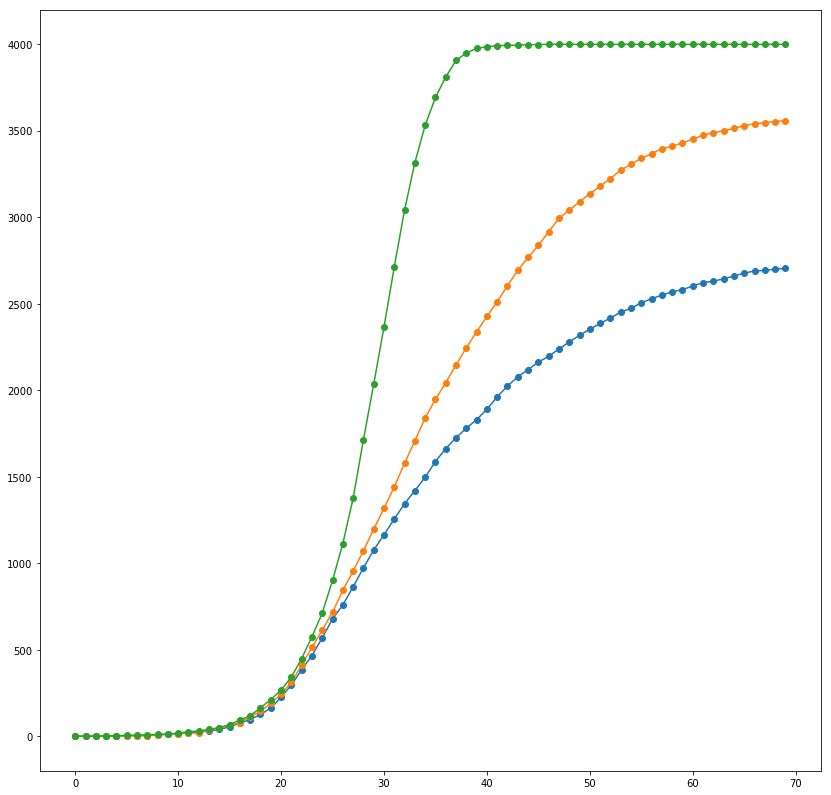

In [152]:
def sim_sequence(sim, n):
    for i in range(n):
        yield sim.history[i]['broadcasts']

plt.figure(figsize=(14, 14))
for sim in (masked, quarantine_40, control):
    plt.plot(range(70), list(sim_sequence(sim, 70)), 'o-')